In [67]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('../hovernet')
sys.path.append('../deconvplugin')

import json
import os
import pickle
import torch
import scanpy as sc

PATH = '/home/luca/Documents/data/'

#'/cluster/CBIO/data1/lgortana/'
#'/home/luca/Documents/data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from deconvplugin.model.cell_classifier import CellClassifier

cc = CellClassifier("resnet50", num_classes=6, hidden_dims=[512, 256])
random_tensor = torch.randn(1, 3, 64, 64)

In [69]:
cc.backbone(random_tensor).shape

torch.Size([1, 2048])

# Load data

In [70]:
#load images
adata_name = 'CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma'
data_path = os.path.join(PATH, adata_name)
image_path = os.path.join(data_path, "tif/CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image.tif")
image_dict = torch.load(os.path.join(data_path, "image_dict_64.pt"))

In [71]:
#load model infos
model_dir = '../models/alpha_0_lr_0.0001_weights_False_divergence_kl_conv_sim_balanced_new/'

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [72]:
import pandas as pd

#load ground truth
ground_truth = pd.read_csv(os.path.join(data_path, f'sim/6_moco_clusters_700spots_balanced_15mean_15var_gt.csv'), index_col=0)
ground_truth.index = ground_truth.index.astype(str)

In [73]:
preds = {}
preds["pred_best"] = model_info["preds"]["pred_best"][model_info["preds"]["pred_best"].index.isin(ground_truth.index)]
preds["pred_final"] = model_info["preds"]["pred_final"][model_info["preds"]["pred_final"].index.isin(ground_truth.index)]

In [74]:
from deconvplugin.analysis.pred_analyzer import PredAnalyzer

analyzer = PredAnalyzer(model_info=model_info,
                        model_state="final",
                        preds=preds, 
                        ground_truth=ground_truth, 
                        image_dict=image_dict)

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


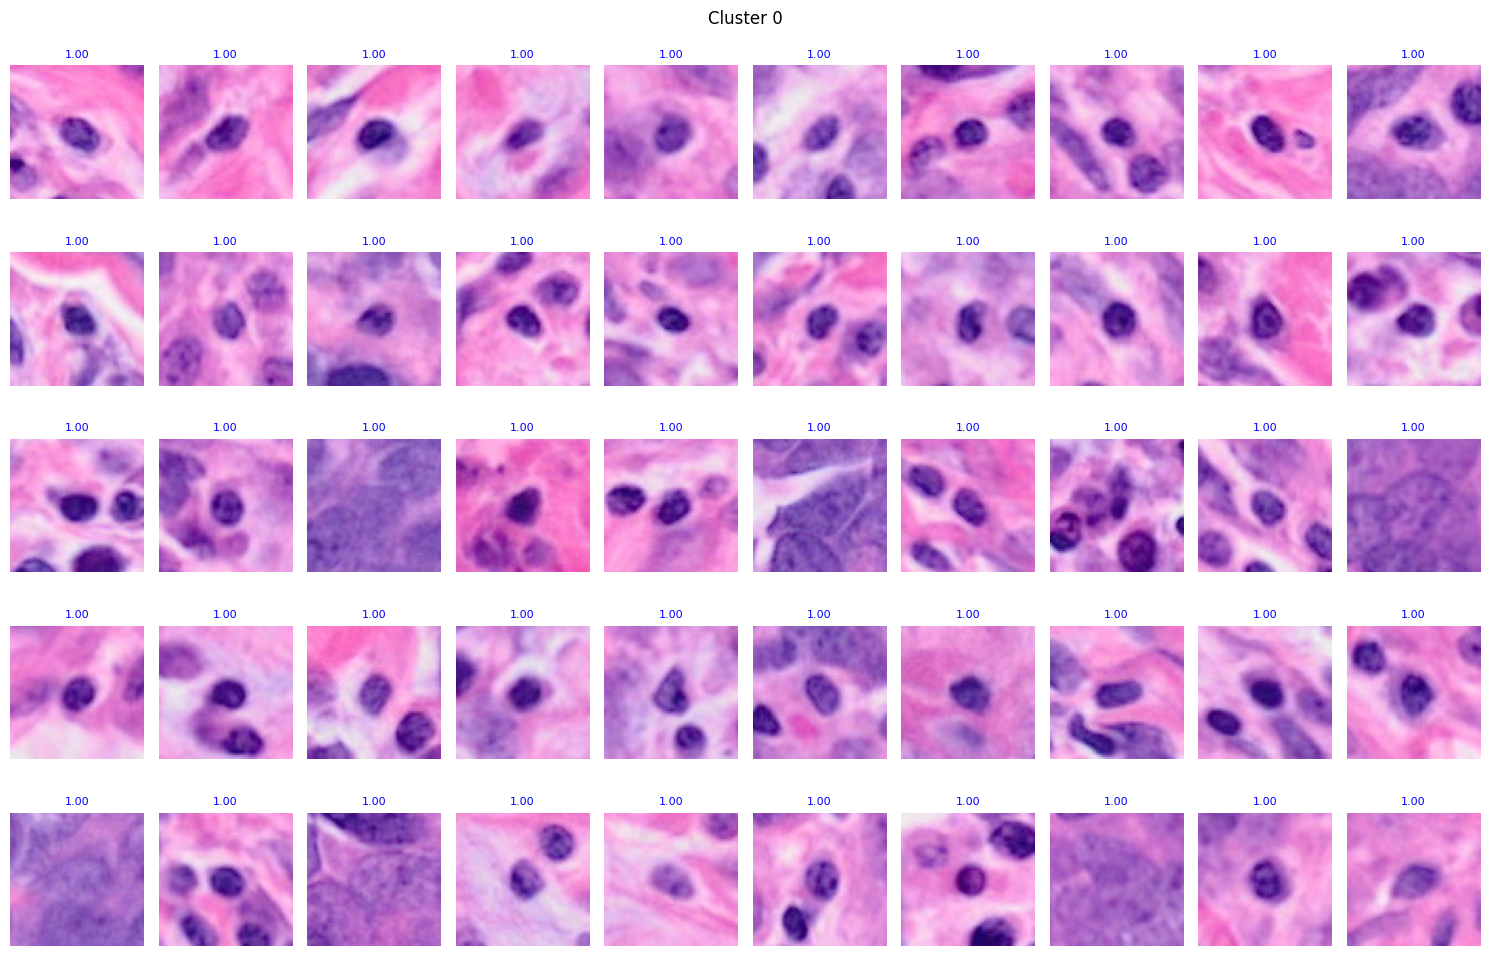

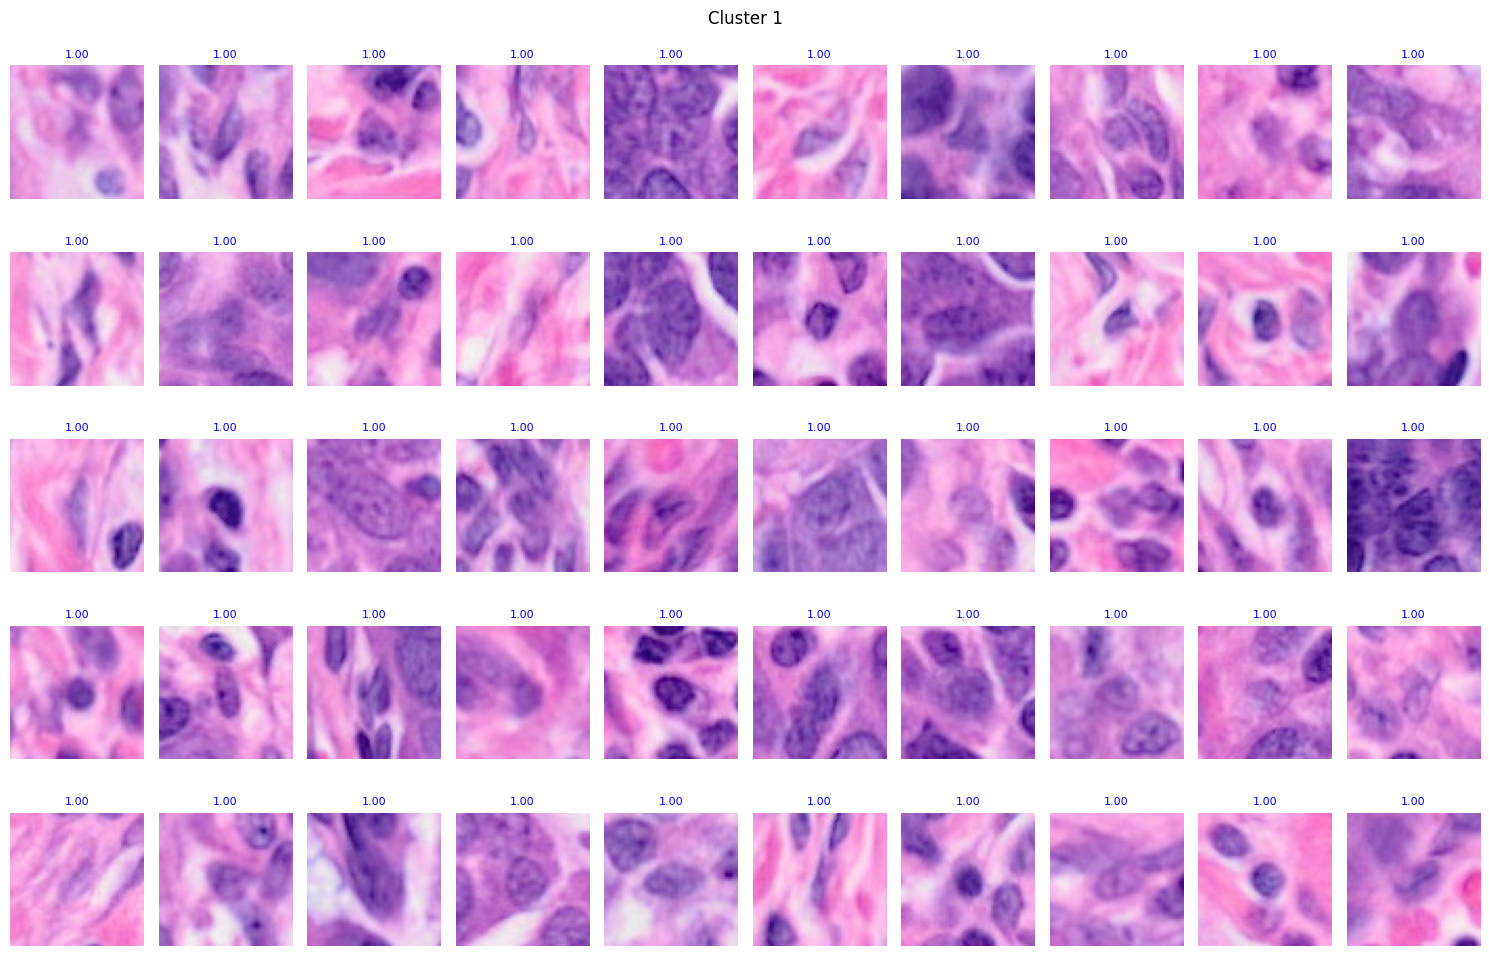

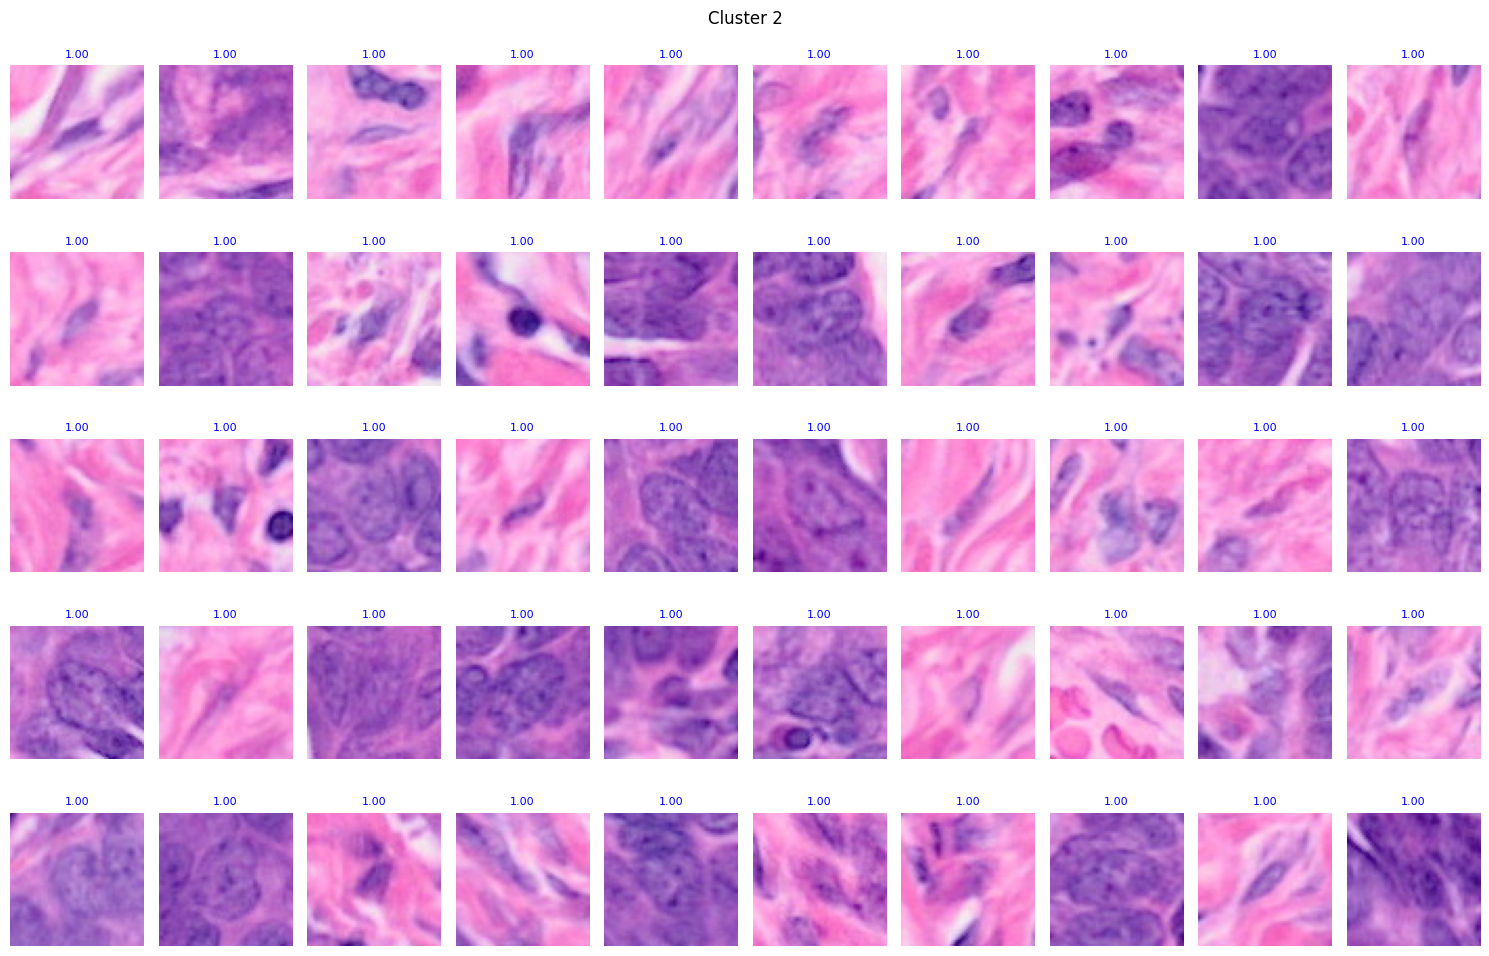

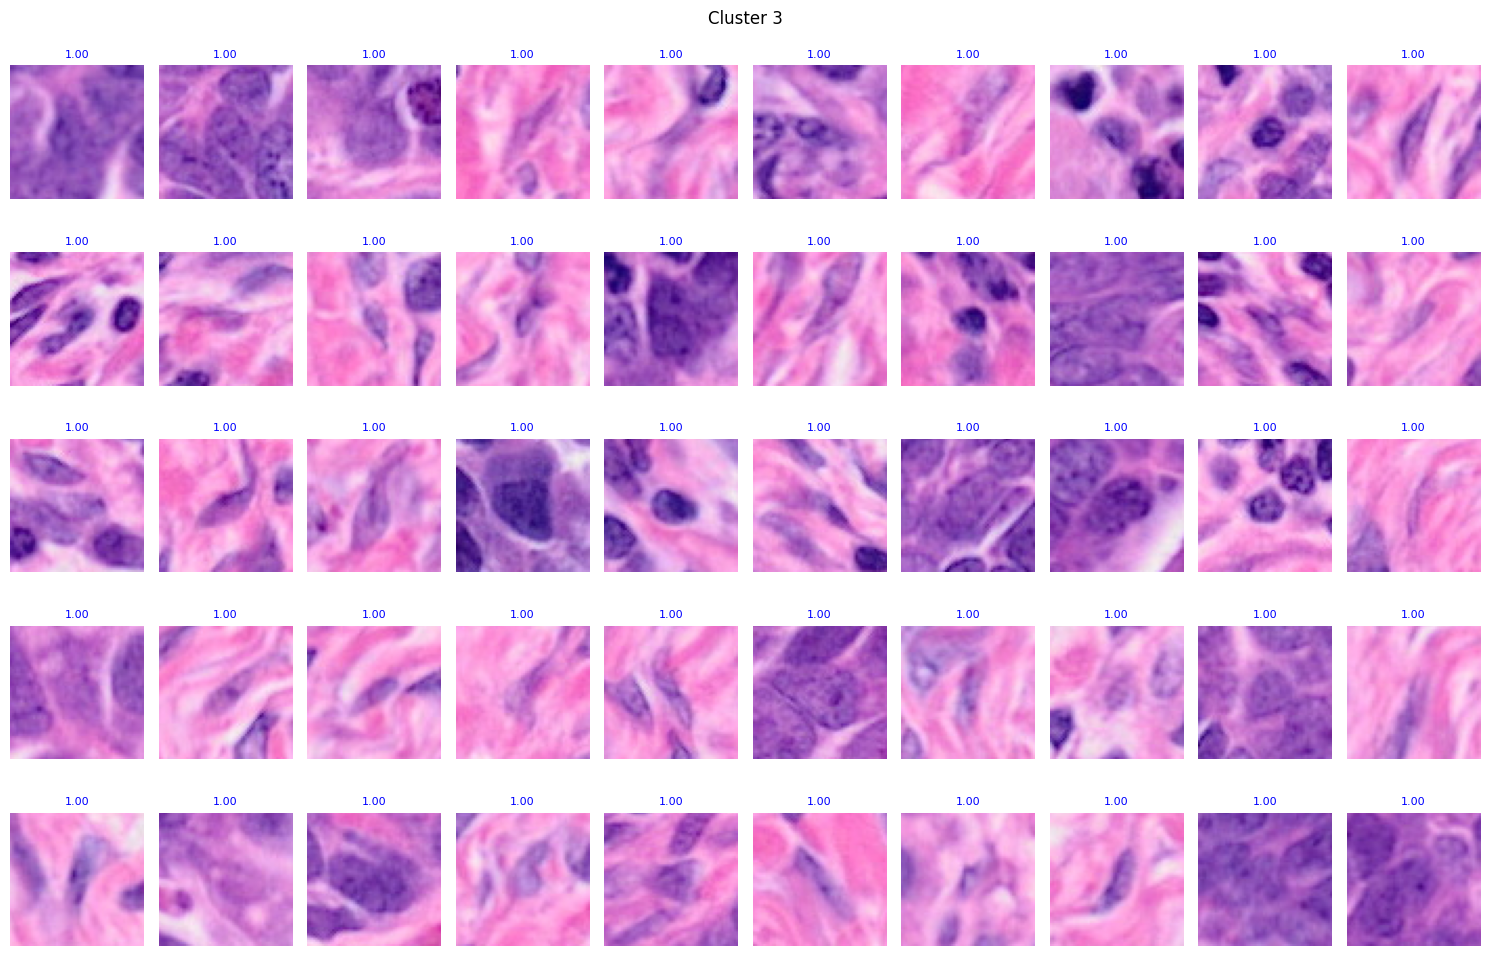

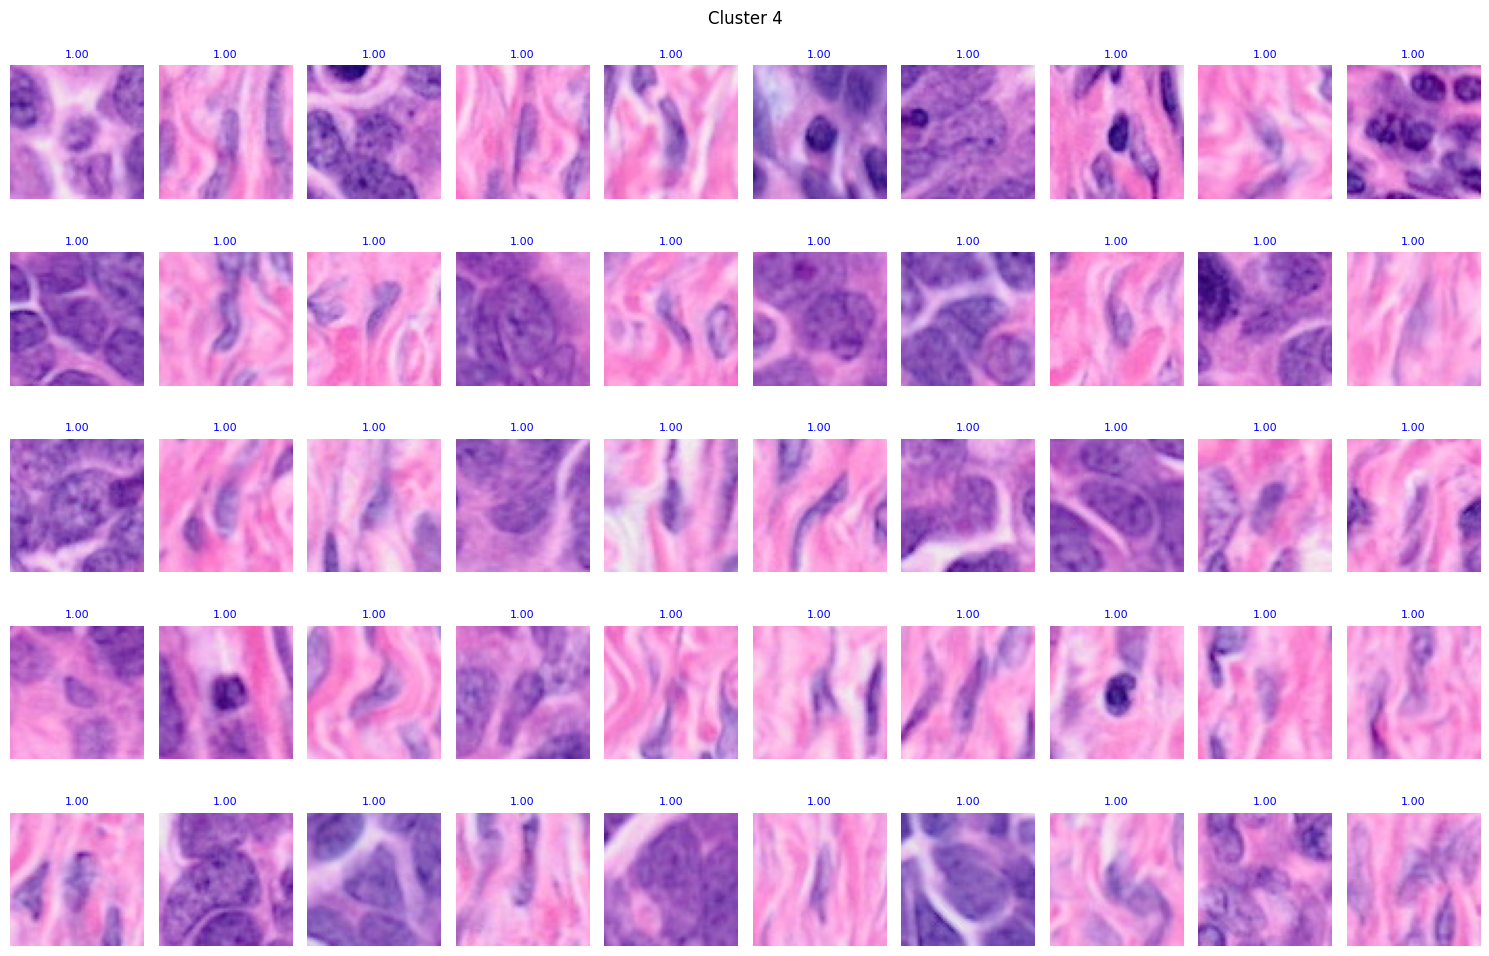

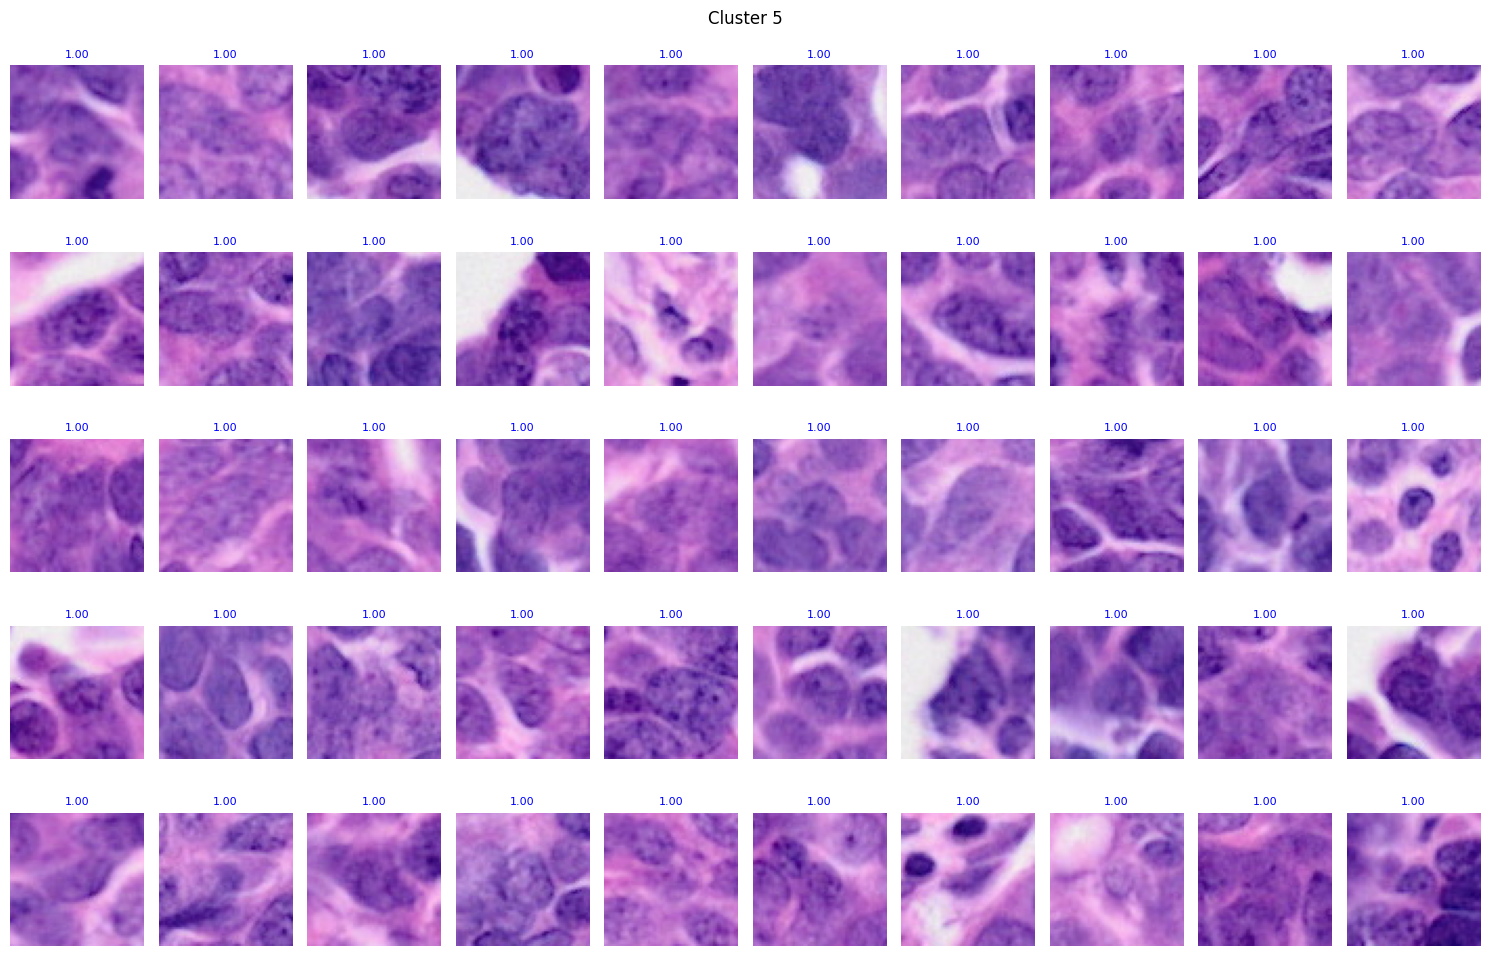

In [75]:
for ct in analyzer.ct_list:
    analyzer.plot_grid_celltype(cell_type=ct, n=50, selection="max", display=True)

Randomly selected spot_id: 345


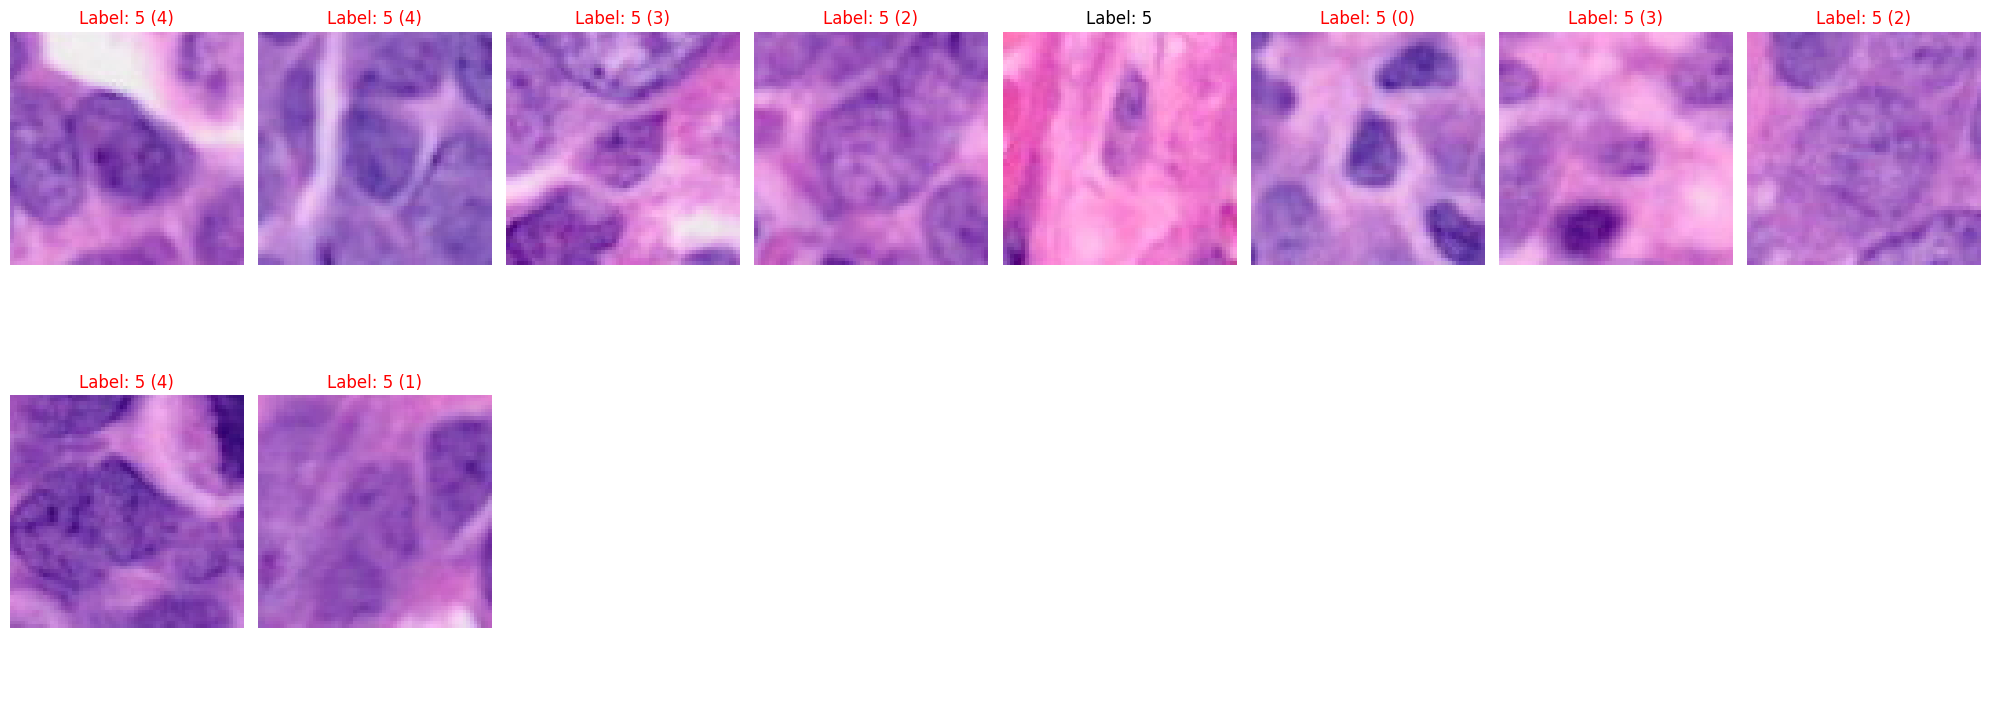

In [11]:
analyzer.plot_mosaic_cells()

In [15]:
analyzer.evaluate_spot_predictions()

{'Spearman Correlation': -0.007105349528084532,
 'Pearson Correlation': -0.00893742932793575,
 'Weighted MSE': 0.008509974191553549,
 'MSE': 0.0509833889262406,
 'Weighted MAE': 0.03161160088519995,
 'MAE': 0.18950854415469917,
 'R^2 Score': -3.6359142859947156,
 'Balanced Accuracy': 0.16666666666666666,
 'Weighted F1 Score': 0.025714285714285714,
 'Weighted Precision': 0.0144,
 'Weighted Recall': 0.12}

In [104]:
perf = analyzer.evaluate_cell_predictions()

In [105]:
perf

{'Global Accuracy': 0.5364166666666667,
 'Balanced Accuracy': 0.5364166666666667,
 'Weighted F1 Score': 0.5291527378085631,
 'F1 Score (Per Class)': {'Cluster 0': 0.860056657223796,
  'Cluster 1': 0.3262379565314811,
  'Cluster 2': 0.5918544194107452,
  'Cluster 3': 0.6368788142981692,
  'Cluster 4': 0.7598885793871867,
  'Cluster 5': 0.0},
 'Weighted Precision': 0.5387154746559021,
 'Precision (Per Class)': {'Cluster 0': 0.9921568627450981,
  'Cluster 1': 0.29557450263905805,
  'Cluster 2': 0.52217125382263,
  'Cluster 3': 0.5645285935085008,
  'Cluster 4': 0.8578616352201258,
  'Cluster 5': 0.0},
 'Weighted Recall': 0.5364166666666667,
 'Recall (Per Class)': {'Cluster 0': 0.759,
  'Cluster 1': 0.364,
  'Cluster 2': 0.683,
  'Cluster 3': 0.7305,
  'Cluster 4': 0.682,
  'Cluster 5': 0.0},
 'Confusion Matrix': array([[1518,  214,   33,  177,   53,    5],
        [   0,  728,  487,   88,   66,  631],
        [   0,  302, 1366,   14,    6,  312],
        [   7,  274,  105, 1461,   92,   6

In [106]:
pd.DataFrame(perf["Confusion Matrix"], index=analyzer.ct_list, columns=analyzer.ct_list)

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  Cluster 5
Cluster 0       1518        214         33        177         53          5
Cluster 1          0        728        487         88         66        631
Cluster 2          0        302       1366         14          6        312
Cluster 3          7        274        105       1461         92         61
Cluster 4          1        206         83        142       1364        204
Cluster 5          4        739        542        706          9          0